## Load the graphs

In [96]:
import pickle
import networkx as nx

# Load the graph from the pickle file
with open('graph_flights_ana.pickle', 'rb') as f:
   G_flights_full = pickle.load(f)

with open('graph_LDA_ana.pickle', 'rb') as f:
   G_lda_full = pickle.load(f)
   
# Unfreeze the graphs if they are frozen
if nx.is_frozen(G_flights_full):
    G_flights = nx.Graph(G_flights_full)  # Re-create the graph to unfreeze it

if nx.is_frozen(G_lda_full):
    G_lda = nx.Graph(G_lda_full)  # Re-create the graph to unfreeze it

### Remove isolated node

In [95]:
print("Before removing isolated nodes")
print(f'G_flights: {G_flights.number_of_nodes()} nodes, {G_flights.number_of_edges()} edges')
print(f'G_lda: {G_lda.number_of_nodes()} nodes, {G_lda.number_of_edges()} edges')

isolated_nodes_flights = list(nx.isolates(G_flights))
G_flights.remove_nodes_from(isolated_nodes_flights)

# Find and remove isolated nodes for G_lda
isolated_nodes_lda = list(nx.isolates(G_lda))
G_lda.remove_nodes_from(isolated_nodes_lda)

print(f'G_flights: {G_flights.number_of_nodes()} nodes, {G_flights.number_of_edges()} edges')
print(f'G_lda: {G_lda.number_of_nodes()} nodes, {G_lda.number_of_edges()} edges')

Before removing isolated nodes
G_flights: 1955 nodes, 12270 edges
G_lda: 1955 nodes, 12270 edges
G_flights: 1894 nodes, 12270 edges
G_lda: 1233 nodes, 12270 edges


### Caluclate Jaccard similarity between the neighbours of cities

In [63]:
def jaccard_similarity_across_graphs(G1, G2, node):
    # Get the neighbors of the node in both graphs
    neighbors1 = set(G1.neighbors(node))
    neighbors2 = set(G2.neighbors(node))
    
    # Calculate the intersection and union
    intersection = len(neighbors1 & neighbors2)
    union = len(neighbors1 | neighbors2)
    
    # Jaccard similarity formula
    if union == 0:  # Handle case where both sets of neighbors are empty
        return 0.0
    else:
        return intersection / union

In [64]:
import statistics

node_sim = {}

for flight_node in G_flights.nodes():
   if flight_node in G_lda.nodes():
      # calcualte similarty
      sim = jaccard_similarity_across_graphs(G_flights, G_lda, flight_node)
      if sim == 1:
         print("node", flight_node)
         print("flight neighbours",list(G_flights.neighbors(flight_node)))
         print("similarty neighbours",list(G_lda.neighbors(flight_node)))
      # save the similarty
      node_sim[flight_node] = sim
      
similarites = list(node_sim.values())

# Calculating various statistics
mean = statistics.mean(similarites)
median = statistics.median(similarites)
stdev = statistics.stdev(similarites)
variance = statistics.variance(similarites)
minimum = min(similarites)
maximum = max(similarites)
range_value = maximum - minimum

# Printing the results
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {stdev}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Range: {range_value}")

node Tortola
flight neighbours ['Dominica']
similarty neighbours ['Dominica']
Mean: 0.018692069392517663
Median: 0.0
Standard Deviation: 0.05138496582297078
Variance: 0.002640414712627875
Minimum: 0.0
Maximum: 1.0
Range: 1.0


### Comparison from gpt

In [65]:
import numpy as np
import networkx as nx
import itertools

def cut_weight(graph, S, T):
    """
    Calculate the cut weight for a directed, weighted graph.
    Parameters:
        graph: A NetworkX graph (directed/weighted).
        S: A set of nodes.
        T: The complementary set of nodes.
    Returns:
        Cut weight: Total weight of edges crossing from S to T.
    """
    cut_wt = 0
    for u, v in graph.edges():
        if u in S and v in T:
            cut_wt += graph[u][v].get('weight', 1)  # Default weight is 1
    return cut_wt

def cut_distance(graph1, graph2, num_samples=100):
    """
    Approximate the cut distance between two directed, weighted graphs.
    Parameters:
        graph1, graph2: Two NetworkX graphs with the same node set.
        num_samples: Number of random partitions to approximate the maximum.
    Returns:
        Approximate cut distance between the graphs.
    """
    # Ensure both graphs have the same set of nodes
    if set(graph1.nodes()) != set(graph2.nodes()):
        raise ValueError("Graphs must have the same node set.")

    nodes = list(graph1.nodes())
    n = len(nodes)
    max_diff = 0

    # Generate random bipartitions for approximation
    for _ in range(num_samples):
        np.random.shuffle(nodes)
        split = n // 2
        S = set(nodes[:split])
        T = set(nodes[split:])

        # Calculate cut weights for both graphs
        cut1 = cut_weight(graph1, S, T)
        cut2 = cut_weight(graph2, S, T)

        # Update the maximum difference
        max_diff = max(max_diff, abs(cut1 - cut2))

    # Normalize by the number of nodes for scale invariance
    return max_diff / n

# Example Usage
# Create two example graphs
G1 = nx.DiGraph()
G2 = nx.DiGraph()

# Add nodes
nodes = range(6)
G1.add_nodes_from(nodes)
G2.add_nodes_from(nodes)

# Add weighted edges
edges_G1 = [(0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6)]
edges_G2 = [(0, 1, 2), (1, 2, 1), (2, 3, 5), (3, 4, 1), (4, 5, 3)]

G1.add_weighted_edges_from(edges_G1)
G2.add_weighted_edges_from(edges_G2)

# Compute cut distance
distance = cut_distance(G1, G2, num_samples=1000)
print(f"Approximate Cut Distance: {distance}")


Approximate Cut Distance: 1.0


In [66]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Sample Graph Creation for Demonstration
# Replace this with your actual graphs
nodes_of_lda = list(G_lda.nodes())
G_airlines = G_flights # .subgraph(nodes_of_lda).copy()
G_similarity = G_lda

# 1. Compare Nodes
def compare_nodes(graph1, graph2):
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    common_nodes = nodes1 & nodes2
    print(f"Nodes in both graphs: {len(common_nodes)}")
    print(f"Nodes only in Graph 1: {len(nodes1 - nodes2)}")
    print(f"Nodes only in Graph 2: {len(nodes2 - nodes1)}")
    return common_nodes



common_nodes = compare_nodes(G_airlines, G_similarity)

# 2. Node Centrality Comparison
def compute_node_centrality(graph, centrality_type='degree'):
    if centrality_type == 'degree':
        return nx.degree_centrality(graph)
    elif centrality_type == 'closeness':
        return nx.closeness_centrality(graph)
    elif centrality_type == 'betweenness':
        return nx.betweenness_centrality(graph)
    else:
        raise ValueError("Invalid centrality type")

centrality_airlines = compute_node_centrality(G_airlines)
centrality_similarity = compute_node_centrality(G_similarity)

print("Centrality airline: ",centrality_airlines)
print("Centrality airline: ",centrality_similarity)

airlines_values = []
similarity_values = []
for city in centrality_airlines.keys():
    if city in centrality_similarity.keys():
        airlines_values.append(centrality_airlines[city])
        similarity_values.append(centrality_similarity[city])    
    

# Compare centralities (example: Pearson correlation)
airlines_values = np.array(airlines_values)
similarity_values = np.array(similarity_values)
correlation = pearsonr(airlines_values, similarity_values)
print(f"Centrality Correlation (Pearson): {correlation[0]:.3f}")

Nodes in both graphs: 1195
Nodes only in Graph 1: 699
Nodes only in Graph 2: 38
Centrality airline:  {'Sochi': 0.008452192287374538, 'Kazan': 0.010565240359218173, 'Dushanbe': 0.01584786053882726, 'Chisinau': 0.012150026413100899, 'Minsk 2': 0.021130480718436345, 'Tashkent': 0.028526148969889066, 'Trabzon': 0.003169572107765452, 'Yerevan': 0.016376122556788168, 'Krasnodar': 0.016904384574749076, 'Moscow': 0.11674590596936081, 'Istanbul': 0.11727416798732171, 'St. Petersburg': 0.060221870047543584, 'Omsk': 0.007395668251452721, 'Yekaterinburg': 0.028526148969889066, 'Khudzhand': 0.010036978341257264, 'Krasnoyarsk': 0.013734812466983624, 'Astrakhan': 0.003169572107765452, 'Chelyabinsk': 0.006867406233491812, 'Belgorod': 0.004754358161648178, 'Antalya': 0.03169572107765452, 'Dubai': 0.09403063919704174, 'Sharjah': 0.040147913365029056, 'Fergana': 0.003169572107765452, 'Samarkand': 0.003169572107765452, 'Alma-ata': 0.021130480718436345, 'Ufa': 0.009508716323296355, 'Bishkek': 0.01056524035

Edge Weight Correlation (Pearson): 0.109
Edge Weight Correlation (Spearman): 0.147
Edge Weight Correlation (Pearson): 0.109
Edge Weight Correlation (Spearman): 0.147
Metrics for Airline Graph:
Average Path Length: None
Clustering Coefficient: 0.5039169710527049
Graph Diameter: None
Metrics for Similarity Graph:
Average Path Length: None
Clustering Coefficient: 0.6851384901711574
Graph Diameter: None
Communities in Airline Graph:
Detected 42 communities
Communities in Similarity Graph:
Detected 133 communities
Number of common edges: 629


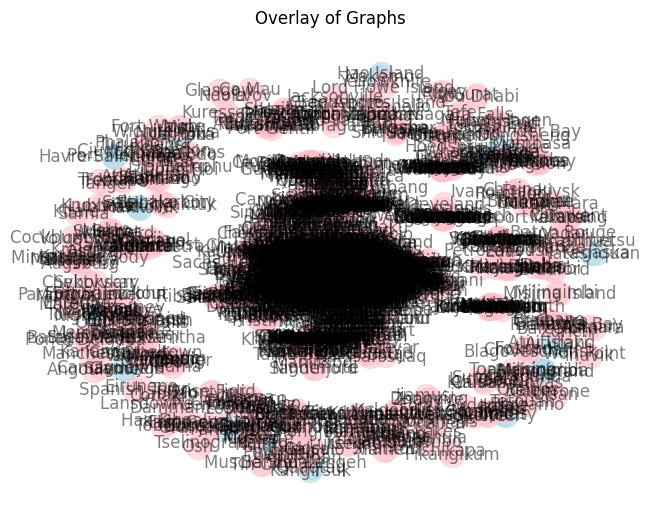

In [67]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler

def compare_edge_weights(graph1, graph2):
    common_edges = set(graph1.edges()) & set(graph2.edges())
    
    if len(common_edges) < 2:
        print(f"Not enough common edges to calculate correlation. Found {len(common_edges)} common edges.")
        return None, None
    
    weights1 = np.array([graph1[u][v]['weight'] for u, v in common_edges])
    weights2 = np.array([graph2[u][v]['weight'] for u, v in common_edges])
    
    # Normalize the weights to a range of 0 to 1
    scaler = MinMaxScaler()
    weights1 = scaler.fit_transform(weights1.reshape(-1, 1)).flatten()
    weights2 = scaler.fit_transform(weights2.reshape(-1, 1)).flatten()
    
    # Calculate correlations
    corr_pearson = pearsonr(weights1, weights2)
    corr_spearman = spearmanr(weights1, weights2)
    
    print(f"Edge Weight Correlation (Pearson): {corr_pearson[0]:.3f}")
    print(f"Edge Weight Correlation (Spearman): {corr_spearman[0]:.3f}")
    
    return corr_pearson, corr_spearman

compare_edge_weights(G_airlines, G_similarity)


# 3. Compare Edge Weights not applicable due the different numbers of neighbors
def compare_edge_weights(graph1, graph2):
    common_edges = set(graph1.edges()) & set(graph2.edges())
    
    if len(common_edges) < 2:
        print(f"Not enough common edges to calculate correlation. Found {len(common_edges)} common edges.")
        return None, None
    
    weights1 = np.array([graph1[u][v]['weight'] for u, v in common_edges])
    weights2 = np.array([graph2[u][v]['weight'] for u, v in common_edges])
    
    corr_pearson = pearsonr(weights1, weights2)
    corr_spearman = spearmanr(weights1, weights2)
    
    print(f"Edge Weight Correlation (Pearson): {corr_pearson[0]:.3f}")
    print(f"Edge Weight Correlation (Spearman): {corr_spearman[0]:.3f}")
    
    return corr_pearson, corr_spearman

compare_edge_weights(G_airlines, G_similarity)

# 4. Global Metrics
def compute_graph_metrics(graph):
    avg_path_length = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None
    clustering_coefficient = nx.average_clustering(graph)
    graph_diameter = nx.diameter(graph) if nx.is_connected(graph) else None
    print(f"Average Path Length: {avg_path_length}")
    print(f"Clustering Coefficient: {clustering_coefficient}")
    print(f"Graph Diameter: {graph_diameter}")

print("Metrics for Airline Graph:")
compute_graph_metrics(G_airlines)

print("Metrics for Similarity Graph:")
compute_graph_metrics(G_similarity)

# 5. Community Detection
def detect_communities(graph):
    from networkx.algorithms.community import greedy_modularity_communities
    communities = list(greedy_modularity_communities(graph))
    print(f"Detected {len(communities)} communities")
    return communities

print("Communities in Airline Graph:")
communities_airlines = detect_communities(G_airlines)

print("Communities in Similarity Graph:")
communities_similarity = detect_communities(G_similarity)

# 6. Overlay Analysis
def overlay_graphs(graph1, graph2):
    common_edges = set(graph1.edges()) & set(graph2.edges())
    print(f"Number of common edges: {len(common_edges)}")
    nx.draw(graph1, with_labels=True, node_color='lightblue', edge_color='blue', alpha=0.5)
    nx.draw(graph2, with_labels=True, node_color='pink', edge_color='red', alpha=0.5)
    plt.title("Overlay of Graphs")
    plt.show()

overlay_graphs(G_airlines, G_similarity)


In [68]:
def jaccard_similarity_edges(graph1, graph2):
   # Get the sets of edges for each graph
   edges1 = set(graph1.edges())
   edges2 = set(graph2.edges())
   
   # Compute intersection and union of the edge sets
   intersection = edges1 & edges2
   union = edges1 | edges2
   
   # Compute Jaccard similarity
   jaccard_sim = len(intersection) / len(union) if len(union) > 0 else 0.0
   
   print(f"Number of edges in Graph 1: {len(edges1)}")
   print(f"Number of edges in Graph 2: {len(edges2)}")
   print(f"Number of common edges: {len(intersection)}")
   print(f"Number of total unique edges: {len(union)}")
   print(f"Jaccard Similarity: {jaccard_sim:.3f}")
   
   return jaccard_sim
 
jaccard_similarity_edges(G_flights, G_lda)

Number of edges in Graph 1: 12270
Number of edges in Graph 2: 12270
Number of common edges: 629
Number of total unique edges: 23911
Jaccard Similarity: 0.026


0.026305884321023796

Edges
12270
12270


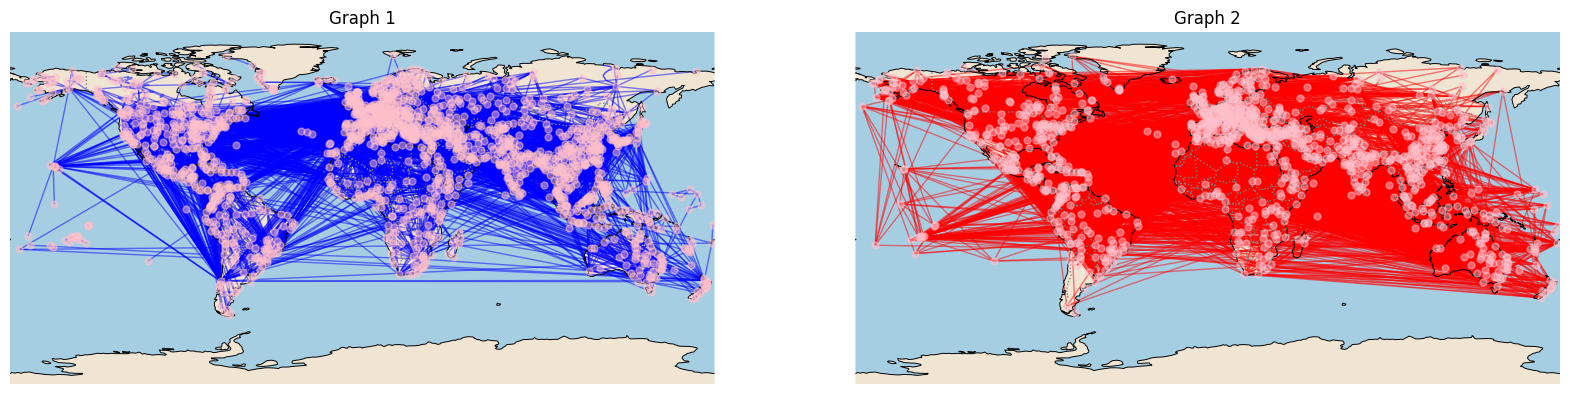

nodes
1894
1233


In [93]:
def overlay_graphs(graph1, graph2):
    import matplotlib.pyplot as plt
    import networkx as nx
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    positions = {node: data['coords'] for node, data in graph1.nodes(data=True)}
    positions = positions | {node: data['coords'] for node, data in graph2.nodes(data=True)}

    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Enhanced map styling for the first graph
    ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.LAND, facecolor="#f0e4d3")
    ax1.add_feature(cfeature.OCEAN, facecolor="#a6cee3")
    ax1.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax1.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
    ax1.add_feature(cfeature.LAKES, facecolor="#a6cee3", edgecolor="blue", alpha=0.5)
    ax1.add_feature(cfeature.RIVERS, edgecolor="blue", alpha=0.7)

    # Draw the first graph
    nx.draw(graph1, pos=positions, node_color='pink', node_size=25, edge_color='blue', alpha=0.5, ax=ax1)
    ax1.set_title("Graph 1")

    # Enhanced map styling for the second graph
    ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax2.add_feature(cfeature.LAND, facecolor="#f0e4d3")
    ax2.add_feature(cfeature.OCEAN, facecolor="#a6cee3")
    ax2.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax2.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

    # Draw the second graph
    nx.draw(graph2, pos=positions, node_color='pink', node_size=25, edge_color='red', alpha=0.5, ax=ax2)
    ax2.set_title("Graph 2")

    plt.show()

print("Edges")
print(len(G_flights.edges()))
print(len(G_lda.edges()))
overlay_graphs(G_flights, G_lda)
print("nodes")
print(len(G_flights.nodes()))
print(len(G_lda.nodes()))

In [88]:
from scipy.sparse import dok_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import identity
from scipy.sparse import diags
from numpy.linalg import inv
from numpy import concatenate
from numpy import square
from numpy import array
from numpy import trace
from numpy import amax
from math import sqrt

def GenAdjacentMatrix(graph):
    '''
    Get adjacent matrix from file
    '''
    #data = pd.read_table(f, delimiter=' ', header=None)
    #i = data[0]
    #j = data[1]
    #size = max([max(i), max(j)])
    size = graph.number_of_nodes()
    #adjacent = dok_matrix((size, size), dtype=np.int)
    adjacent = dok_matrix((size, size), dtype=int)
    # for k in range(len(i)):
    #     adjacent[i[k] - 1, j[k] - 1] = 1
    #     adjacent[j[k] - 1, i[k] - 1] = 1
    # for k in range(size):
    #     adjacent[k, k] = 0
    node_to_index = {node: idx for idx, node in enumerate(graph.nodes())}

    for edge in graph.edges():
        i = node_to_index[edge[0]]  # Convert the first node (city) to an index
        j = node_to_index[edge[1]]
        adjacent[i, j] = 1
        adjacent[j, i] = 1
    
    return adjacent

def Partition(num, size):
    '''
    Randomly divide size nodes into num groups
    '''
    partitions = {}
    nodes = [x for x in range(1, size + 1)]
    group_size = int(size / num)
    for i in range(num - 1):
        partitions[i] = []
        for j in range(group_size):
            node = random.choice(nodes)
            nodes.remove(node)
            partitions[i].append(node)

    # The last partition gets the rest of the nodes
    partitions[num - 1] = nodes[:]

    return partitions

def Partition2e(partitions, size):
    '''
    Change partition into e vector
    size is the dimension n
    '''
    e = {}
    for p in partitions:
        e[p] = []
        for i in range(1, size + 1):
            if i in partitions[p]:
                e[p].append(1.0)
            else:
                e[p].append(0.0)
    return e

def InverseMatrix(A, partitions):
    '''
    Use Fast Belief Propagation
    CITATION: Danai Koutra, Tai-You Ke, U. Kang, Duen Horng Chau, Hsing-Kuo
    Kenneth Pao, Christos Faloutsos
    Unifying Guilt-by-Association Approaches
    return [I+a*D-c*A]^-1
    '''
    num = len(partitions)  # The number of partitions

    I = identity(A.shape[0])  # Identity matrix
    D = diags(sum(A).toarray(), [0])  # Diagonal degree matrix

    c1 = trace(D.toarray()) + 2
    c2 = trace(square(D).toarray()) - 1
    h_h = sqrt((-c1 + sqrt(c1 * c1 + 4 * c2)) / (8 * c2))

    a = 4 * h_h * h_h / (1 - 4 * h_h * h_h)
    c = 2 * h_h / (1 - 4 * h_h * h_h)

    M = c * A - a * D
    for i in range(num):
        inv = array([partitions[i][:]]).T
        mat = array([partitions[i][:]]).T
        power = 1
        while amax(M.toarray()) > 10**(-9) and power < 10:
            mat = M.dot(mat)
            inv += mat
            power += 1
        if i == 0:
            MatrixR = inv
        else:
            MatrixR = concatenate((MatrixR, array(inv)), axis=1)

    S = csc_matrix(MatrixR)
    return S

def Similarity(A1, A2, g):
    '''
    Use DeltaCon to compute similarity
    CITATION: Danai Koutra, Joshua T. Vogelstein, Christos Faloutsos
    DELTACON: A Principled Massive-Graph Similarity Function
    g is the number of partitions
    '''
    size = A1.shape[0]

    partitions = Partition(g, size)
    e = Partition2e(partitions, size)
    
    S1 = InverseMatrix(A1, e)
    S2 = InverseMatrix(A2, e)

    d = 0
    for i in range(size):
        for j in range(g):
            d += (sqrt(S1[i, j]) - sqrt(S2[i, j]))**2
    d = sqrt(d)
    sim = 1 / (1 + d)
    return sim

def DeltaCon(A1, A2, g):
    # Compute average similarity
    Iteration = 10
    average = 0.0
    for i in range(Iteration):
        average += Similarity(A1, A2, g)
    average /= Iteration
    return average

In [98]:
#perform deltacon
A1 = GenAdjacentMatrix(G_flights_full)
A2 = GenAdjacentMatrix(G_lda_full)
similarity = DeltaCon(A1, A2, 10)
print(f"DeltaCon Similarity: {similarity:.3f}")

(1955, 1955)
(1955, 1955)
DeltaCon Similarity: 0.058


In [99]:
import networkx as nx
import numpy as np
from scipy.spatial.distance import euclidean, cityblock, canberra
from sklearn.preprocessing import MinMaxScaler

def compare_weighted_graphs(graph1, graph2):
    # Get the union of edges from both graphs
    edges_union = set(graph1.edges()) | set(graph2.edges())

    # Normalize weights across both graphs
    all_weights = []
    for edge in edges_union:
        w1 = graph1[edge[0]][edge[1]].get('weight', 0) if graph1.has_edge(*edge) else 0
        w2 = graph2[edge[0]][edge[1]].get('weight', 0) if graph2.has_edge(*edge) else 0
        all_weights.append((w1, w2))

    # Convert weights to numpy array for normalization
    weights_array = np.array(all_weights)
    scaler = MinMaxScaler()
    normalized_weights = scaler.fit_transform(weights_array)

    # Split normalized weights into two arrays
    weights1 = normalized_weights[:, 0]
    weights2 = normalized_weights[:, 1]

    # Calculate distances
    euclidean_dist = euclidean(weights1, weights2)
    manhattan_dist = cityblock(weights1, weights2)
    canberra_dist = canberra(weights1, weights2)

    # Calculate Jaccard distance based on edge presence
    edges_graph1 = set(graph1.edges())
    edges_graph2 = set(graph2.edges())
    intersection = len(edges_graph1 & edges_graph2)
    union = len(edges_graph1 | edges_graph2)
    jaccard_dist = 1 - intersection / union if union > 0 else 1  # 1 if no union

    # Print results
    print(f"Euclidean Distance (EUC): {euclidean_dist:.4f}")
    print(f"Manhattan Distance (MAN): {manhattan_dist:.4f}")
    print(f"Canberra Distance (CAN): {canberra_dist:.4f}")
    print(f"Jaccard Distance (JAC): {jaccard_dist:.4f}")

# Example Usage
# Create two graphs with the same nodes but different edges and weight

# Compare the graphs
compare_weighted_graphs(G_flights_full, G_lda_full)


Euclidean Distance (EUC): 110.5596
Manhattan Distance (MAN): 13114.4378
Canberra Distance (CAN): 23802.0051
Jaccard Distance (JAC): 0.9737



Interpretation of Graph Distance Results:
Here’s how to interpret your results:

1. Euclidean Distance (EUC): 110.5596
What it represents:
The straight-line distance in the normalized weight space between the two graphs.
A smaller value indicates that the weights of corresponding edges in the two graphs are more similar.
Interpretation:
A distance of 110.5596 suggests some level of disparity between the normalized weights of the edges in the two graphs. However, without a reference for "large" or "small" in your specific context, this should be compared relative to distances for other similar graphs.

3. Canberra Distance (CAN): 23802.0051
What it represents:
A weighted measure of proportional differences. Each difference is divided by the sum of the corresponding weights, penalizing larger relative differences more heavily.
Useful for comparing graphs with weights of vastly different magnitudes.
Interpretation:
The high Canberra distance suggests substantial relative differences in edge weights across the graphs. It indicates that for many edges, the weights differ significantly as a proportion of their combined values.

3. Canberra Distance (CAN): 23802.0051
What it represents:
A weighted measure of proportional differences. Each difference is divided by the sum of the corresponding weights, penalizing larger relative differences more heavily.
Useful for comparing graphs with weights of vastly different magnitudes.
Interpretation:
The high Canberra distance suggests substantial relative differences in edge weights across the graphs. It indicates that for many edges, the weights differ significantly as a proportion of their combined values.

4. Jaccard Distance (JAC): 0.9737
What it represents:
A measure of dissimilarity between the edge sets of the graphs.
1.0 means the edge sets are completely disjoint, while 0.0 means they are identical.
Interpretation:
A Jaccard distance of 0.9737 implies that the two graphs have very few common edges. Most edges in one graph do not appear in the other, regardless of weight. This indicates significant structural differences between the graphs.